In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset

from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

import os
import re
import cv2
from tqdm import tqdm
from pathlib import Path
import albumentations as A
import plotly.express as px
from albumentations.pytorch import ToTensorV2
from PIL import Image

In [2]:
PATH = "/home/jupyter/datasphere/project/"
TRAIN_DIR = PATH + 'data/train'
TEST_DIR = PATH + "data/test"
MODEL_SAVE_PATH = PATH + 'best_model.pth'

## 1. Анализ датасета

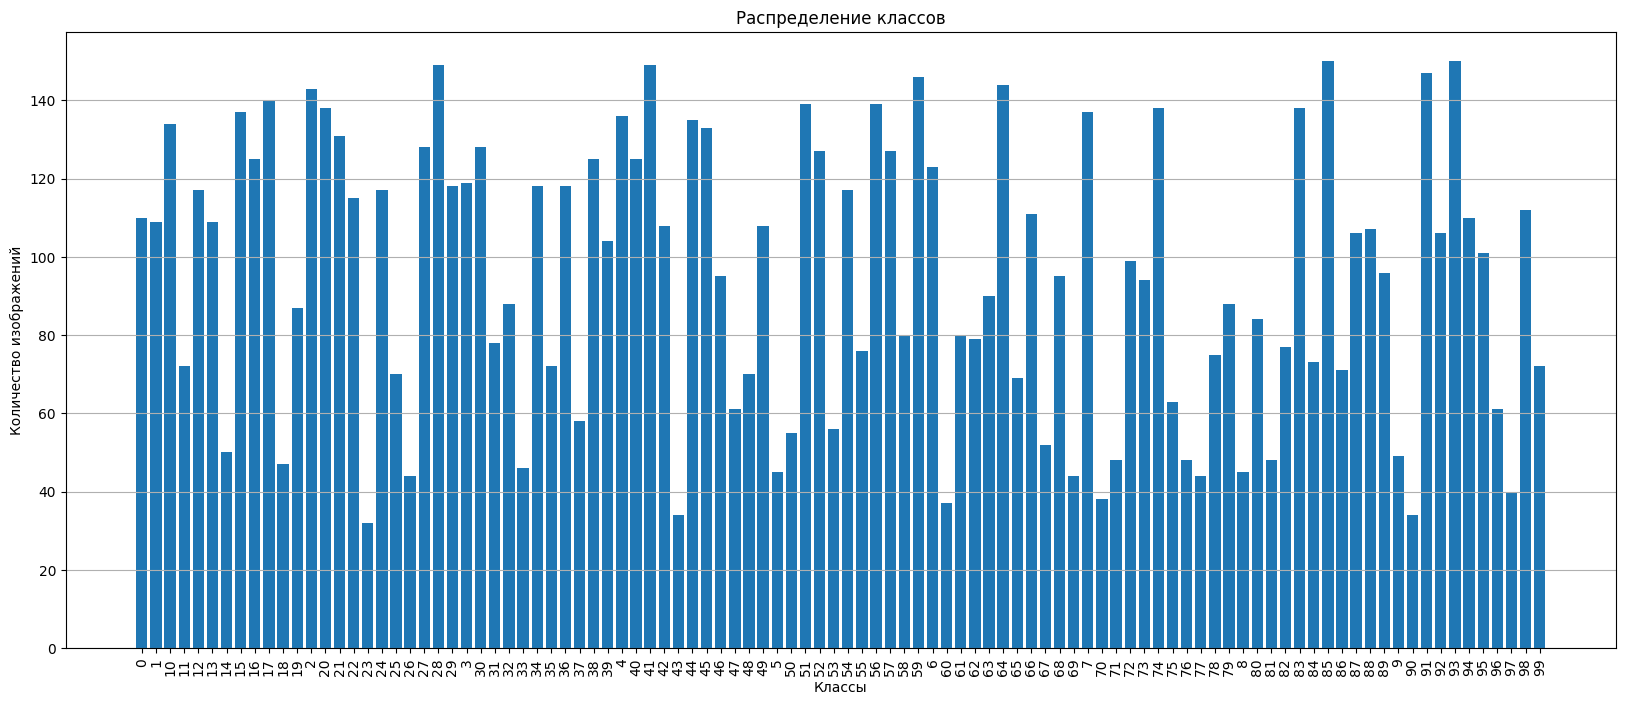

Среднее количество изображений на класс: 95.1
Стандартное отклонение: 35.3
Максимальное количество: 150
Минимальное количество: 32


In [3]:
dataset = ImageFolder(TRAIN_DIR, transform=transforms.ToTensor())
data_loader = DataLoader(dataset, batch_size=32)
class_counts = Counter(dataset.targets)

plt.figure(figsize=(20, 8))
plt.bar(range(len(class_counts)), class_counts.values())
plt.xticks(range(len(class_counts)), dataset.classes, rotation=90)
plt.xlabel('Классы')
plt.ylabel('Количество изображений')
plt.title('Распределение классов')
plt.grid(axis='y')
plt.show()

# 2. Анализ дисбаланса
mean_count = np.mean(list(class_counts.values()))
std_count = np.std(list(class_counts.values()))
print(f"Среднее количество изображений на класс: {mean_count:.1f}")
print(f"Стандартное отклонение: {std_count:.1f}")
print(f"Максимальное количество: {max(class_counts.values())}")
print(f"Минимальное количество: {min(class_counts.values())}")

# 3. Просмотр примеров изображений
def denormalize(image_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return image_tensor * std + mean

def plot_class_samples(dataset, n_samples=5):
    plt.figure(figsize=(20, 20))
    class_indices = {cls: [] for cls in dataset.classes}
    
    for idx, (_, label) in enumerate(dataset):
        class_indices[dataset.classes[label]].append(idx)
    
    for i, cls in enumerate(dataset.classes):
        indices = np.random.choice(class_indices[cls], n_samples, replace=False)
        for j, idx in enumerate(indices):
            ax = plt.subplot(len(dataset.classes), n_samples, i*n_samples + j + 1)
            img, _ = dataset[idx]
            img = denormalize(img).permute(1, 2, 0).numpy()
            plt.imshow(np.clip(img, 0, 1))
            plt.title(f"{cls}" if j == 0 else "")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Используем оригинальные изображения без аугментаций для просмотра
# original_dataset = ImageFolder(DATA_PATH, transform=transforms.ToTensor())
# plot_class_samples(original_dataset)

Analyzing images: 100%|██████████| 9510/9510 [00:08<00:00, 1121.00it/s]


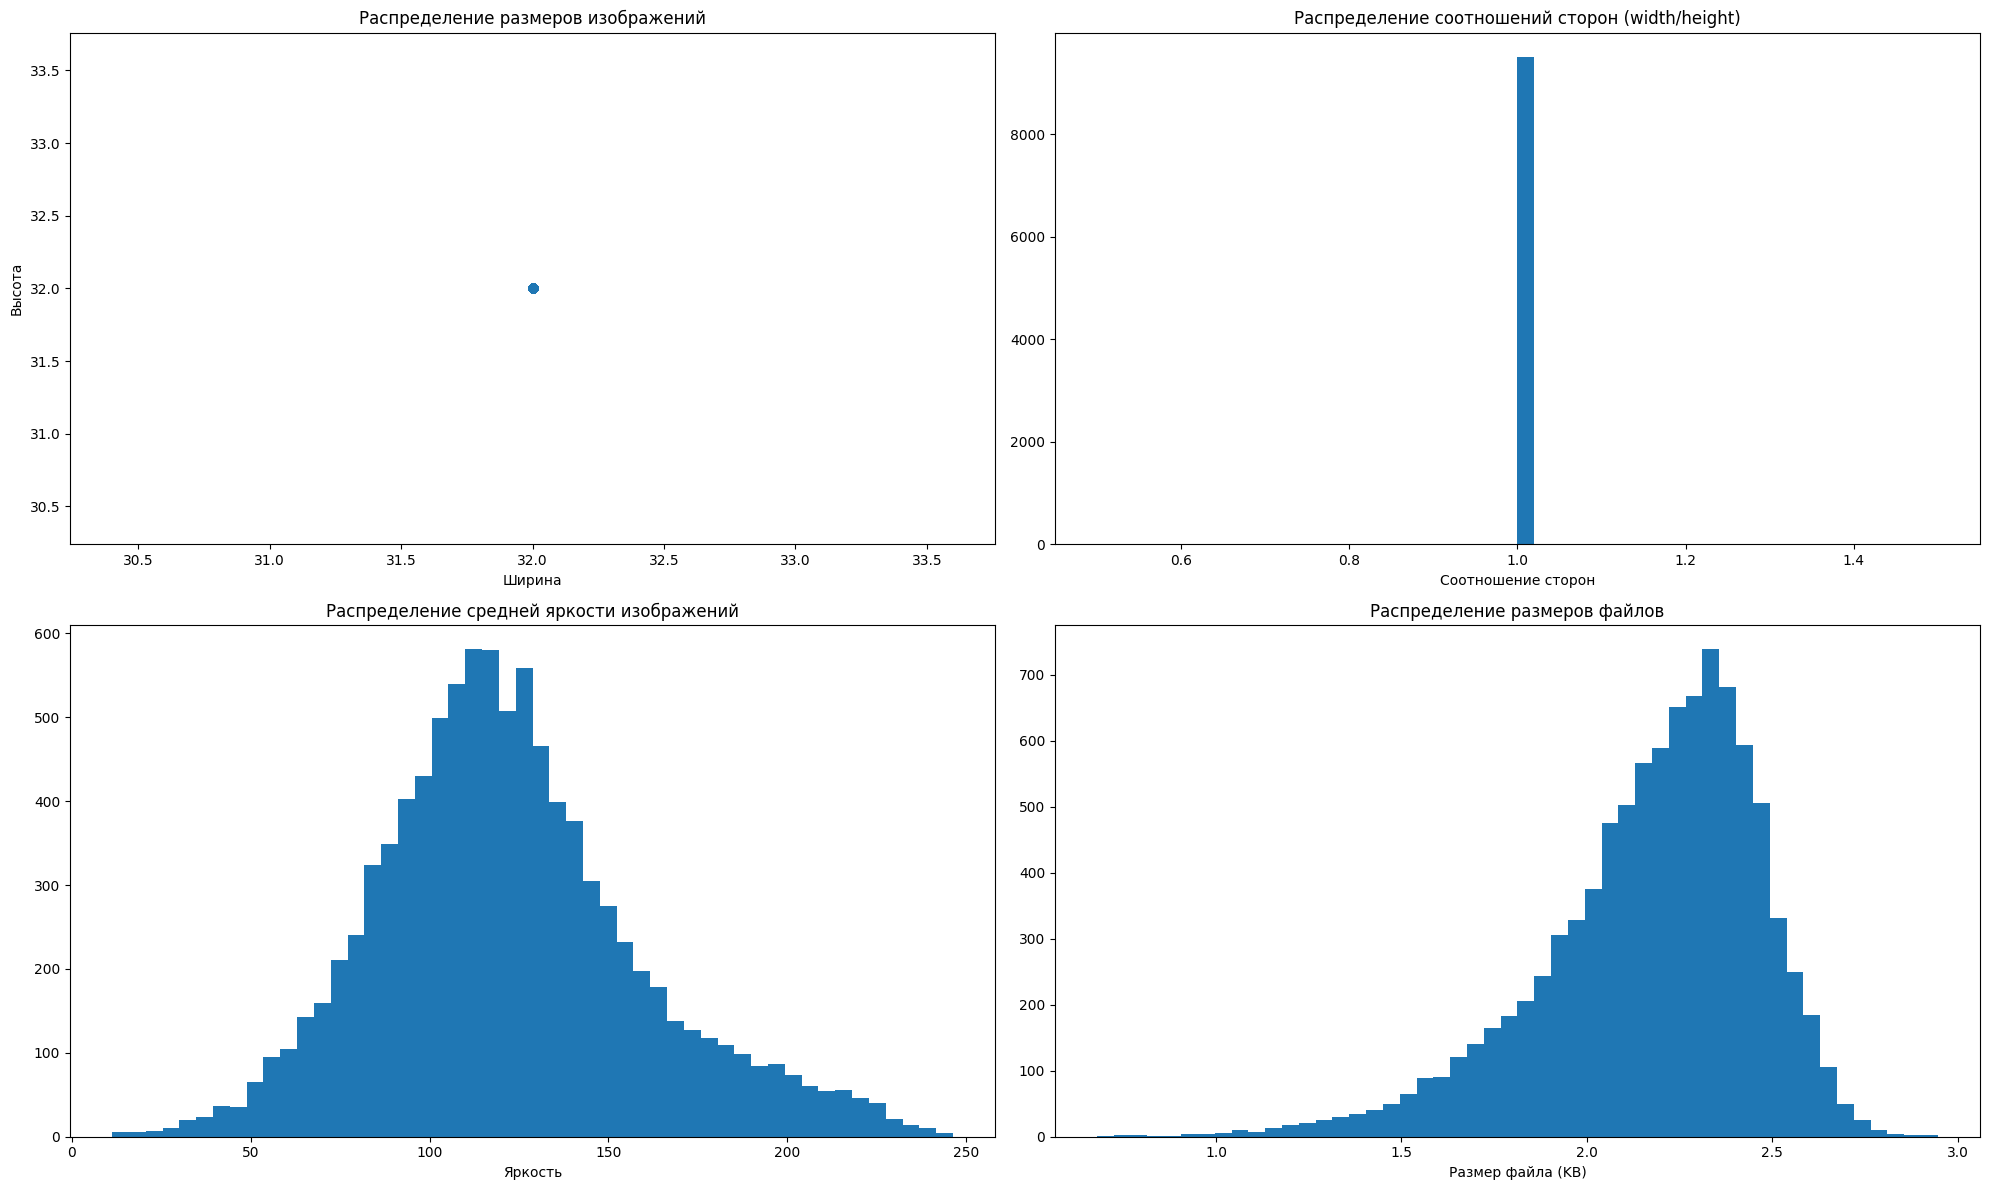

Color analysis: 100%|██████████| 1000/1000 [00:00<00:00, 5548.95it/s]


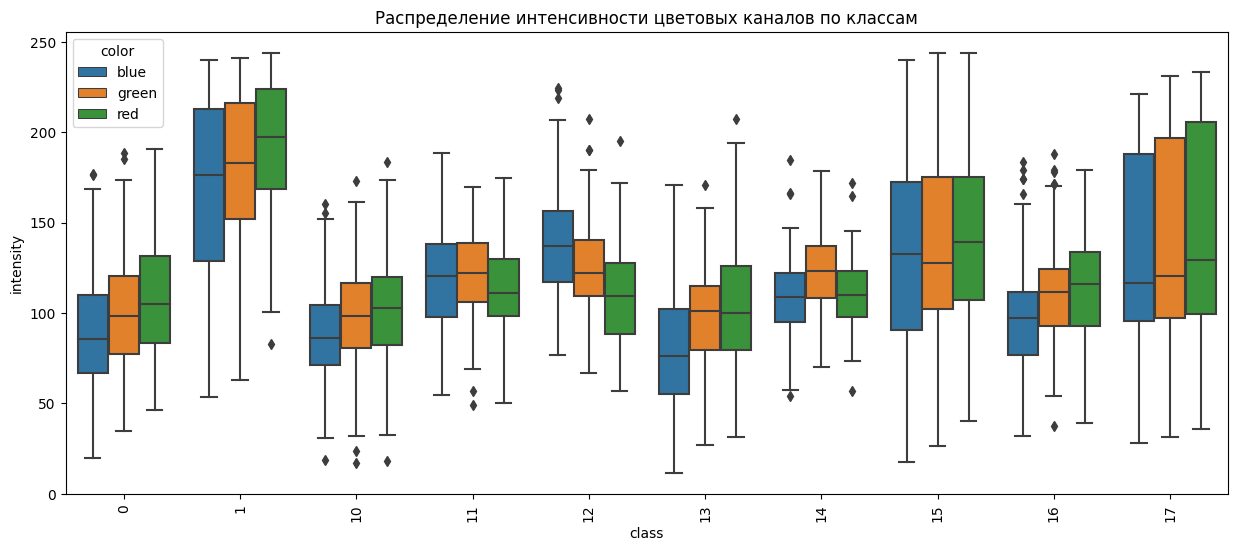


Основные выводы:
1. Общее количество изображений: 9510
2. Уникальные размеры изображений: 1
3. Средний размер файла: 2.2 KB
4. Максимальная яркость: 246.4
5. Минимальная яркость: 11.2


In [4]:
def extended_data_analysis(data_path):
    # 1. Сбор расширенной статистики
    dataset = ImageFolder(data_path)
    image_paths = [str(p) for p in Path(data_path).glob('**/*.*')]
    
    stats = []
    for path in tqdm(image_paths, desc='Analyzing images'):
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        stats.append({
            'width': img.shape[1],
            'height': img.shape[0],
            'aspect_ratio': img.shape[1]/img.shape[0],
            'mean_intensity': img.mean(),
            'class': Path(path).parent.name,
            'file_size': Path(path).stat().st_size
        })
    
    df = pd.DataFrame(stats)
    
    # 2. Визуализация характеристик
    plt.figure(figsize=(20, 12))
    
    # Распределение размеров изображений
    plt.subplot(2, 2, 1)
    plt.scatter(df['width'], df['height'], alpha=0.3)
    plt.title('Распределение размеров изображений')
    plt.xlabel('Ширина')
    plt.ylabel('Высота')
    
    # Распределение соотношений сторон
    plt.subplot(2, 2, 2)
    plt.hist(df['aspect_ratio'], bins=50)
    plt.title('Распределение соотношений сторон (width/height)')
    plt.xlabel('Соотношение сторон')
    
    # Распределение яркости
    plt.subplot(2, 2, 3)
    plt.hist(df['mean_intensity'], bins=50)
    plt.title('Распределение средней яркости изображений')
    plt.xlabel('Яркость')
    
    # Размеры файлов
    plt.subplot(2, 2, 4)
    plt.hist(df['file_size']/(1024), bins=50)  # в килобайтах
    plt.title('Распределение размеров файлов')
    plt.xlabel('Размер файла (KB)')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Интерактивная визуализация распределений
    fig = px.box(df, x='class', y='mean_intensity', 
                title='Распределение яркости по классам')
    fig.show()
    
    # 4. Анализ цветовых каналов
    color_stats = []
    for path in tqdm(image_paths[:1000], desc='Color analysis'):  # ограничим выборку
        img = cv2.imread(path)
        for i, color in enumerate(['blue', 'green', 'red']):
            color_stats.append({
                'color': color,
                'intensity': img[:,:,i].mean(),
                'class': Path(path).parent.name
            })
    
    color_df = pd.DataFrame(color_stats)
    plt.figure(figsize=(15, 6))
    sns.boxplot(x='class', y='intensity', hue='color', data=color_df)
    plt.title('Распределение интенсивности цветовых каналов по классам')
    plt.xticks(rotation=90)
    plt.show()
    
    # 5. Выводы
    print("\nОсновные выводы:")
    print(f"1. Общее количество изображений: {len(df)}")
    print(f"2. Уникальные размеры изображений: {len(df[['width', 'height']].drop_duplicates())}")
    print(f"3. Средний размер файла: {df['file_size'].mean()/1024:.1f} KB")
    print(f"4. Максимальная яркость: {df['mean_intensity'].max():.1f}")
    print(f"5. Минимальная яркость: {df['mean_intensity'].min():.1f}")
    
    return df

# Запуск анализа
df = extended_data_analysis(TRAIN_DIR)

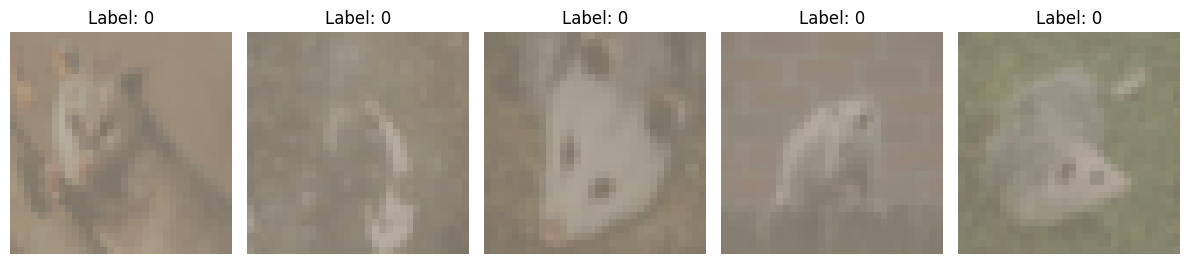

In [5]:
# Пример визуализации
import matplotlib.pyplot as plt

def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Денормализация
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

images, labels = next(iter(data_loader))
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    imshow(images[i], f'Label: {labels[i].item()}')
plt.tight_layout()
plt.show()

## 2. Аугментационный пайплайн

In [6]:
# Для тренировочных данных: два вида, сложный и простой
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
train_transformV2 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.HueSaturationValue(hue_shift_limit=30, sat_shift_limit=40, val_shift_limit=30, p=0.5),
    A.CoarseDropout(max_holes=2, max_height=16, max_width=16, p=0.3),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Для валидационных данных
val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Для тестовых данных
test_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

### Подготавливаем данные к загрузке в погрузчик и модель

In [7]:
class TransformSubset(Subset):
    def __init__(self, dataset, indices, transform):
        super().__init__(dataset, indices)
        self.transform = transform
        
    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        
        if self.transform:
            image = self.transform(image=np.array(image))['image']
            
        return image, label

In [8]:
# Загружаем общий датасет
dataset = ImageFolder(
    root=TRAIN_DIR,
    transform=None 
)

# Делим на train/val
train_idx, val_idx = train_test_split(
    np.arange(len(dataset)),
    test_size=0.2,
    stratify=dataset.targets,
    random_state=42
)

### Создаем необходимые надстройки моделей

In [9]:
class CompactCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, 4, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )
        self.classifier = nn.Sequential(
            nn.Linear(int(12.25*128*8), 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 100)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

In [11]:
ensemble_models = [
    models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1),
    models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1),
    models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
]

for model in ensemble_models:
    if isinstance(model, models.EfficientNet):
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 100)
    elif isinstance(model, models.ResNet):
        model.fc = nn.Linear(model.fc.in_features, 100)
    elif isinstance(model, models.VGG):
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, 100)
    else:
        raise ValueError(f"Unsupported model type: {type(model)}")
    model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 91.6MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.1MB/s]
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 116MB/s]  


In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    history = {"train_acc": [],
               "val_acc": [],
               "train_loss": [],
               "val_loss": []}
    
    for epoch in range(epochs):
        
        # Train
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        history["train_loss"].append(epoch_loss)
        epoch_acc = correct / total
        history["train_acc"].append(epoch_acc)
    
        # Eval
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
        valid_loss = running_loss / len(val_loader)
        history["val_loss"].append(valid_loss)
        valid_acc = correct / total
        history["val_acc"].append(valid_acc)
        scheduler.step(correct / total)

        print(f'Epoch {epoch+1}/{epochs}\nTrain Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')
        print(f"Valid Loss: {valid_loss:.4f}, Acc: {valid_acc:.4f}")
    return history

In [13]:
def plot_graph(history):
    epochs = range(len(history["train_loss"]))
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label='Train Loss')
    plt.plot(epochs, history["val_loss"], label='Val Loss')
    plt.title('Losses')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label='Train Accuracy')
    plt.plot(epochs, history["val_acc"], label='Val Accuracy')
    plt.title('Accuracies')
    plt.legend()
    plt.grid(True)

## 3. Обучаем модели

### Модель без трансфер-леринг и с простой аугментацией

In [14]:
train_dataset = TransformSubset(dataset, train_idx, train_transform)
val_dataset = TransformSubset(dataset, val_idx, val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [15]:
model1 = CompactCNN().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='max', factor=0.5, patience=3, verbose=True)
history1 = train_model(model1, train_loader, val_loader, criterion, optimizer1, scheduler1, epochs=50)

Validation: 100%|██████████| 15/15 [00:00<00:00, 32.32it/s]


Epoch 1/50
Train Loss: 4.5533, Train Accuracy: 0.0244
Valid Loss: 4.4388, Acc: 0.0442


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.46it/s]


Epoch 2/50
Train Loss: 4.3635, Train Accuracy: 0.0570
Valid Loss: 4.2696, Acc: 0.0599


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.11it/s]


Epoch 3/50
Train Loss: 4.1924, Train Accuracy: 0.0772
Valid Loss: 4.1322, Acc: 0.0852


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.22it/s]


Epoch 4/50
Train Loss: 4.0678, Train Accuracy: 0.0965
Valid Loss: 4.0404, Acc: 0.1073


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.56it/s]


Epoch 5/50
Train Loss: 3.9606, Train Accuracy: 0.1128
Valid Loss: 3.9444, Acc: 0.1183


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.63it/s]


Epoch 6/50
Train Loss: 3.8561, Train Accuracy: 0.1296
Valid Loss: 3.8738, Acc: 0.1272


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.75it/s]


Epoch 7/50
Train Loss: 3.7566, Train Accuracy: 0.1460
Valid Loss: 3.8219, Acc: 0.1467


Validation: 100%|██████████| 15/15 [00:00<00:00, 34.00it/s]


Epoch 8/50
Train Loss: 3.6965, Train Accuracy: 0.1502
Valid Loss: 3.7514, Acc: 0.1351


Validation: 100%|██████████| 15/15 [00:00<00:00, 29.85it/s]


Epoch 9/50
Train Loss: 3.6087, Train Accuracy: 0.1648
Valid Loss: 3.6910, Acc: 0.1519


Validation: 100%|██████████| 15/15 [00:00<00:00, 28.49it/s]


Epoch 10/50
Train Loss: 3.5433, Train Accuracy: 0.1798
Valid Loss: 3.6582, Acc: 0.1519


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.32it/s]


Epoch 11/50
Train Loss: 3.4719, Train Accuracy: 0.1885
Valid Loss: 3.6136, Acc: 0.1577


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.91it/s]


Epoch 12/50
Train Loss: 3.4455, Train Accuracy: 0.1955
Valid Loss: 3.5491, Acc: 0.1819


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.46it/s]


Epoch 13/50
Train Loss: 3.3854, Train Accuracy: 0.2018
Valid Loss: 3.4984, Acc: 0.1909


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.84it/s]


Epoch 14/50
Train Loss: 3.3262, Train Accuracy: 0.2116
Valid Loss: 3.5307, Acc: 0.1809


Validation: 100%|██████████| 15/15 [00:00<00:00, 30.99it/s]


Epoch 15/50
Train Loss: 3.2755, Train Accuracy: 0.2246
Valid Loss: 3.4879, Acc: 0.1872


Validation: 100%|██████████| 15/15 [00:00<00:00, 30.83it/s]


Epoch 16/50
Train Loss: 3.2218, Train Accuracy: 0.2383
Valid Loss: 3.4274, Acc: 0.1982


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.41it/s]


Epoch 17/50
Train Loss: 3.1890, Train Accuracy: 0.2433
Valid Loss: 3.4036, Acc: 0.2066


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.37it/s]


Epoch 18/50
Train Loss: 3.1394, Train Accuracy: 0.2475
Valid Loss: 3.3932, Acc: 0.2035


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.12it/s]


Epoch 19/50
Train Loss: 3.1121, Train Accuracy: 0.2580
Valid Loss: 3.3628, Acc: 0.2145


Validation: 100%|██████████| 15/15 [00:00<00:00, 30.97it/s]


Epoch 20/50
Train Loss: 3.0722, Train Accuracy: 0.2637
Valid Loss: 3.3183, Acc: 0.2135


Validation: 100%|██████████| 15/15 [00:00<00:00, 28.82it/s]


Epoch 21/50
Train Loss: 3.0233, Train Accuracy: 0.2764
Valid Loss: 3.3172, Acc: 0.2182


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.36it/s]


Epoch 22/50
Train Loss: 2.9752, Train Accuracy: 0.2821
Valid Loss: 3.2985, Acc: 0.2266


Validation: 100%|██████████| 15/15 [00:00<00:00, 30.52it/s]


Epoch 23/50
Train Loss: 2.9429, Train Accuracy: 0.2910
Valid Loss: 3.2779, Acc: 0.2266


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.65it/s]


Epoch 24/50
Train Loss: 2.8953, Train Accuracy: 0.2953
Valid Loss: 3.2574, Acc: 0.2329


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.51it/s]


Epoch 25/50
Train Loss: 2.8726, Train Accuracy: 0.3049
Valid Loss: 3.2302, Acc: 0.2277


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.05it/s]


Epoch 26/50
Train Loss: 2.8361, Train Accuracy: 0.3067
Valid Loss: 3.2136, Acc: 0.2345


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.45it/s]


Epoch 27/50
Train Loss: 2.7798, Train Accuracy: 0.3195
Valid Loss: 3.2097, Acc: 0.2329


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.00it/s]


Epoch 28/50
Train Loss: 2.7554, Train Accuracy: 0.3222
Valid Loss: 3.1644, Acc: 0.2545


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.75it/s]


Epoch 29/50
Train Loss: 2.7397, Train Accuracy: 0.3229
Valid Loss: 3.1707, Acc: 0.2450


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.18it/s]


Epoch 30/50
Train Loss: 2.6953, Train Accuracy: 0.3354
Valid Loss: 3.1398, Acc: 0.2413


Validation: 100%|██████████| 15/15 [00:00<00:00, 30.92it/s]


Epoch 31/50
Train Loss: 2.6588, Train Accuracy: 0.3482
Valid Loss: 3.1743, Acc: 0.2560


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


Epoch 32/50
Train Loss: 2.6338, Train Accuracy: 0.3452
Valid Loss: 3.1349, Acc: 0.2471


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.71it/s]


Epoch 33/50
Train Loss: 2.5980, Train Accuracy: 0.3541
Valid Loss: 3.1048, Acc: 0.2624


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.12it/s]


Epoch 34/50
Train Loss: 2.5951, Train Accuracy: 0.3562
Valid Loss: 3.0915, Acc: 0.2566


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.40it/s]


Epoch 35/50
Train Loss: 2.5614, Train Accuracy: 0.3582
Valid Loss: 3.0987, Acc: 0.2618


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.34it/s]


Epoch 36/50
Train Loss: 2.5229, Train Accuracy: 0.3669
Valid Loss: 3.1006, Acc: 0.2529


Validation: 100%|██████████| 15/15 [00:00<00:00, 28.84it/s]


Epoch 37/50
Train Loss: 2.4929, Train Accuracy: 0.3713
Valid Loss: 3.0721, Acc: 0.2660


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.49it/s]


Epoch 38/50
Train Loss: 2.4827, Train Accuracy: 0.3793
Valid Loss: 3.0505, Acc: 0.2723


Validation: 100%|██████████| 15/15 [00:00<00:00, 29.46it/s]

Epoch 39/50
Train Loss: 2.4326, Train Accuracy: 0.3870
Valid Loss: 3.0498, Acc: 0.2771



Validation: 100%|██████████| 15/15 [00:00<00:00, 33.25it/s]


Epoch 40/50
Train Loss: 2.4051, Train Accuracy: 0.3860
Valid Loss: 3.0444, Acc: 0.2592


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.49it/s]


Epoch 41/50
Train Loss: 2.3810, Train Accuracy: 0.3975
Valid Loss: 3.0403, Acc: 0.2697


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.33it/s]


Epoch 42/50
Train Loss: 2.3646, Train Accuracy: 0.4044
Valid Loss: 3.0309, Acc: 0.2718


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.57it/s]


Epoch 00043: reducing learning rate of group 0 to 1.5000e-05.
Epoch 43/50
Train Loss: 2.3481, Train Accuracy: 0.4056
Valid Loss: 3.0342, Acc: 0.2702


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.50it/s]


Epoch 44/50
Train Loss: 2.2911, Train Accuracy: 0.4242
Valid Loss: 2.9829, Acc: 0.2839


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.42it/s]


Epoch 45/50
Train Loss: 2.2714, Train Accuracy: 0.4255
Valid Loss: 2.9919, Acc: 0.2855


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.28it/s]


Epoch 46/50
Train Loss: 2.2732, Train Accuracy: 0.4193
Valid Loss: 3.0012, Acc: 0.2723


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.50it/s]


Epoch 47/50
Train Loss: 2.2516, Train Accuracy: 0.4285
Valid Loss: 2.9663, Acc: 0.2818


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.67it/s]


Epoch 48/50
Train Loss: 2.2330, Train Accuracy: 0.4355
Valid Loss: 2.9353, Acc: 0.2892


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.65it/s]


Epoch 49/50
Train Loss: 2.2435, Train Accuracy: 0.4322
Valid Loss: 2.9533, Acc: 0.2892


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.64it/s]

Epoch 50/50
Train Loss: 2.2116, Train Accuracy: 0.4370
Valid Loss: 2.9855, Acc: 0.2739


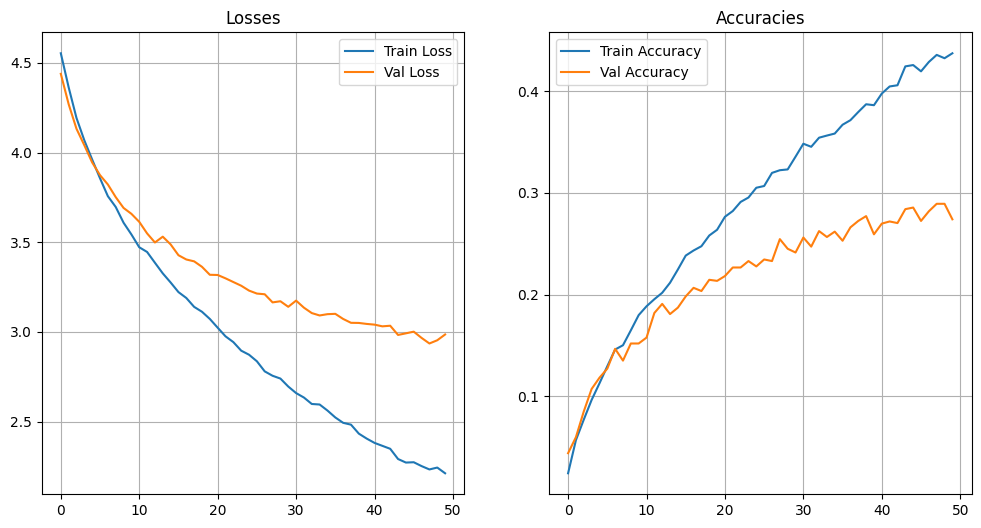

In [16]:
plot_graph(history1)

### Модель с трансфер-лернинг и с простой аугментацией

In [17]:
model2 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, 100)
model2 = model2.to(device)

optimizer2 = optim.Adam(model2.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='max', factor=0.5, patience=3, verbose=True)
history2 = train_model(model2, train_loader, val_loader, criterion, optimizer2, scheduler2, epochs=50)

Validation: 100%|██████████| 15/15 [00:00<00:00, 30.16it/s]


Epoch 1/50
Train Loss: 4.6646, Train Accuracy: 0.0301
Valid Loss: 4.4128, Acc: 0.0594


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.98it/s]


Epoch 2/50
Train Loss: 4.1251, Train Accuracy: 0.1192
Valid Loss: 4.1017, Acc: 0.1267


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.23it/s]


Epoch 3/50
Train Loss: 3.7553, Train Accuracy: 0.1887
Valid Loss: 3.8499, Acc: 0.1709


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.31it/s]


Epoch 4/50
Train Loss: 3.3966, Train Accuracy: 0.2529
Valid Loss: 3.6180, Acc: 0.2093


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


Epoch 5/50
Train Loss: 3.0978, Train Accuracy: 0.3141
Valid Loss: 3.4323, Acc: 0.2361


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.64it/s]


Epoch 6/50
Train Loss: 2.8178, Train Accuracy: 0.3758
Valid Loss: 3.2721, Acc: 0.2650


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.03it/s]


Epoch 7/50
Train Loss: 2.6004, Train Accuracy: 0.4136
Valid Loss: 3.1422, Acc: 0.2813


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.80it/s]


Epoch 8/50
Train Loss: 2.3970, Train Accuracy: 0.4527
Valid Loss: 3.0348, Acc: 0.3028


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.38it/s]


Epoch 9/50
Train Loss: 2.2144, Train Accuracy: 0.4934
Valid Loss: 2.9490, Acc: 0.3186


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.74it/s]


Epoch 10/50
Train Loss: 2.0387, Train Accuracy: 0.5336
Valid Loss: 2.8734, Acc: 0.3265


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.71it/s]


Epoch 11/50
Train Loss: 1.8958, Train Accuracy: 0.5677
Valid Loss: 2.8199, Acc: 0.3333


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.56it/s]


Epoch 12/50
Train Loss: 1.7500, Train Accuracy: 0.6027
Valid Loss: 2.7766, Acc: 0.3481


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.85it/s]


Epoch 13/50
Train Loss: 1.6233, Train Accuracy: 0.6345
Valid Loss: 2.7414, Acc: 0.3528


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.30it/s]


Epoch 14/50
Train Loss: 1.5065, Train Accuracy: 0.6673
Valid Loss: 2.7031, Acc: 0.3580


Validation: 100%|██████████| 15/15 [00:00<00:00, 30.88it/s]


Epoch 15/50
Train Loss: 1.3958, Train Accuracy: 0.6966
Valid Loss: 2.6786, Acc: 0.3607


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.66it/s]


Epoch 16/50
Train Loss: 1.2967, Train Accuracy: 0.7164
Valid Loss: 2.6647, Acc: 0.3638


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.44it/s]


Epoch 17/50
Train Loss: 1.1768, Train Accuracy: 0.7507
Valid Loss: 2.6454, Acc: 0.3686


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.31it/s]


Epoch 18/50
Train Loss: 1.0951, Train Accuracy: 0.7708
Valid Loss: 2.6424, Acc: 0.3733


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.89it/s]


Epoch 19/50
Train Loss: 0.9986, Train Accuracy: 0.8042
Valid Loss: 2.6306, Acc: 0.3733


Validation: 100%|██████████| 15/15 [00:00<00:00, 30.44it/s]


Epoch 20/50
Train Loss: 0.9321, Train Accuracy: 0.8176
Valid Loss: 2.6296, Acc: 0.3733


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.40it/s]


Epoch 21/50
Train Loss: 0.8556, Train Accuracy: 0.8362
Valid Loss: 2.6250, Acc: 0.3780


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.72it/s]


Epoch 22/50
Train Loss: 0.7796, Train Accuracy: 0.8611
Valid Loss: 2.6221, Acc: 0.3822


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.82it/s]


Epoch 23/50
Train Loss: 0.7205, Train Accuracy: 0.8691
Valid Loss: 2.6187, Acc: 0.3812


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.54it/s]


Epoch 24/50
Train Loss: 0.6598, Train Accuracy: 0.8887
Valid Loss: 2.6242, Acc: 0.3796


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.15it/s]


Epoch 25/50
Train Loss: 0.5932, Train Accuracy: 0.9030
Valid Loss: 2.6230, Acc: 0.3812


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.50it/s]


Epoch 26/50
Train Loss: 0.5373, Train Accuracy: 0.9225
Valid Loss: 2.6312, Acc: 0.3833


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.63it/s]


Epoch 27/50
Train Loss: 0.4875, Train Accuracy: 0.9311
Valid Loss: 2.6408, Acc: 0.3817


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.54it/s]


Epoch 28/50
Train Loss: 0.4401, Train Accuracy: 0.9416
Valid Loss: 2.6354, Acc: 0.3828


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.65it/s]


Epoch 29/50
Train Loss: 0.4035, Train Accuracy: 0.9506
Valid Loss: 2.6524, Acc: 0.3822


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.68it/s]


Epoch 00030: reducing learning rate of group 0 to 1.5000e-05.
Epoch 30/50
Train Loss: 0.3620, Train Accuracy: 0.9606
Valid Loss: 2.6579, Acc: 0.3780


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.42it/s]


Epoch 31/50
Train Loss: 0.3300, Train Accuracy: 0.9661
Valid Loss: 2.6640, Acc: 0.3817


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.22it/s]


Epoch 32/50
Train Loss: 0.3093, Train Accuracy: 0.9707
Valid Loss: 2.6679, Acc: 0.3849


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.82it/s]


Epoch 33/50
Train Loss: 0.2974, Train Accuracy: 0.9744
Valid Loss: 2.6696, Acc: 0.3833


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.71it/s]


Epoch 34/50
Train Loss: 0.2769, Train Accuracy: 0.9770
Valid Loss: 2.6717, Acc: 0.3849


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.62it/s]


Epoch 35/50
Train Loss: 0.2631, Train Accuracy: 0.9770
Valid Loss: 2.6769, Acc: 0.3828


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.61it/s]


Epoch 00036: reducing learning rate of group 0 to 7.5000e-06.
Epoch 36/50
Train Loss: 0.2508, Train Accuracy: 0.9808
Valid Loss: 2.6855, Acc: 0.3838


Validation: 100%|██████████| 15/15 [00:00<00:00, 30.41it/s]


Epoch 37/50
Train Loss: 0.2306, Train Accuracy: 0.9833
Valid Loss: 2.6872, Acc: 0.3843


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.54it/s]


Epoch 38/50
Train Loss: 0.2276, Train Accuracy: 0.9850
Valid Loss: 2.6920, Acc: 0.3838


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.92it/s]


Epoch 39/50
Train Loss: 0.2189, Train Accuracy: 0.9865
Valid Loss: 2.6950, Acc: 0.3807


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.34it/s]


Epoch 00040: reducing learning rate of group 0 to 3.7500e-06.
Epoch 40/50
Train Loss: 0.2172, Train Accuracy: 0.9846
Valid Loss: 2.6983, Acc: 0.3828


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.71it/s]


Epoch 41/50
Train Loss: 0.2036, Train Accuracy: 0.9900
Valid Loss: 2.6998, Acc: 0.3822


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.96it/s]


Epoch 42/50
Train Loss: 0.2060, Train Accuracy: 0.9887
Valid Loss: 2.7023, Acc: 0.3849


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.05it/s]


Epoch 43/50
Train Loss: 0.2057, Train Accuracy: 0.9886
Valid Loss: 2.7022, Acc: 0.3843


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.20it/s]


Epoch 00044: reducing learning rate of group 0 to 1.8750e-06.
Epoch 44/50
Train Loss: 0.1972, Train Accuracy: 0.9913
Valid Loss: 2.7051, Acc: 0.3838


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.28it/s]


Epoch 45/50
Train Loss: 0.1923, Train Accuracy: 0.9900
Valid Loss: 2.7055, Acc: 0.3854


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.86it/s]


Epoch 46/50
Train Loss: 0.1950, Train Accuracy: 0.9907
Valid Loss: 2.7056, Acc: 0.3833


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.54it/s]


Epoch 47/50
Train Loss: 0.1864, Train Accuracy: 0.9919
Valid Loss: 2.7061, Acc: 0.3854


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.09it/s]


Epoch 48/50
Train Loss: 0.1925, Train Accuracy: 0.9900
Valid Loss: 2.7073, Acc: 0.3854


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.77it/s]


Epoch 00049: reducing learning rate of group 0 to 9.3750e-07.
Epoch 49/50
Train Loss: 0.1928, Train Accuracy: 0.9892
Valid Loss: 2.7079, Acc: 0.3854


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.51it/s]

Epoch 50/50
Train Loss: 0.1959, Train Accuracy: 0.9912
Valid Loss: 2.7084, Acc: 0.3854


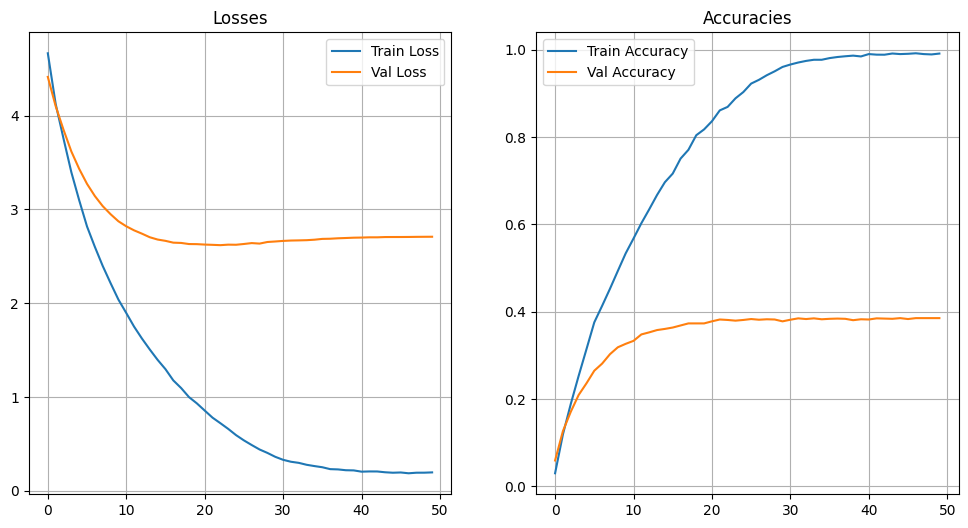

In [18]:
plot_graph(history2)

### Модель без трансфер-лернинг и с продвинутой аугментацией

In [19]:
train_dataset = TransformSubset(dataset, train_idx, train_transformV2)
val_dataset = TransformSubset(dataset, val_idx, val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [20]:
model3 = CompactCNN().to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler3 = optim.lr_scheduler.ReduceLROnPlateau(optimizer3, mode='max', factor=0.5, patience=3, verbose=True)
history3 = train_model(model3, train_loader, val_loader, criterion, optimizer3, scheduler3, epochs=50)

Validation: 100%|██████████| 15/15 [00:00<00:00, 32.58it/s]


Epoch 1/50
Train Loss: 4.5961, Train Accuracy: 0.0174
Valid Loss: 4.4869, Acc: 0.0363


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.43it/s]


Epoch 2/50
Train Loss: 4.4916, Train Accuracy: 0.0327
Valid Loss: 4.3448, Acc: 0.0584


Validation: 100%|██████████| 15/15 [00:00<00:00, 29.56it/s]


Epoch 3/50
Train Loss: 4.3938, Train Accuracy: 0.0455
Valid Loss: 4.2825, Acc: 0.0657


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.95it/s]


Epoch 4/50
Train Loss: 4.3460, Train Accuracy: 0.0526
Valid Loss: 4.1822, Acc: 0.0689


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.77it/s]


Epoch 5/50
Train Loss: 4.2860, Train Accuracy: 0.0585
Valid Loss: 4.1569, Acc: 0.0878


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.16it/s]


Epoch 6/50
Train Loss: 4.2504, Train Accuracy: 0.0569
Valid Loss: 4.1035, Acc: 0.0836


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.86it/s]


Epoch 7/50
Train Loss: 4.2185, Train Accuracy: 0.0618
Valid Loss: 4.0505, Acc: 0.0868


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.16it/s]


Epoch 8/50
Train Loss: 4.1664, Train Accuracy: 0.0728
Valid Loss: 4.0071, Acc: 0.0967


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.52it/s]


Epoch 9/50
Train Loss: 4.1557, Train Accuracy: 0.0787
Valid Loss: 3.9862, Acc: 0.1088


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.97it/s]


Epoch 10/50
Train Loss: 4.1024, Train Accuracy: 0.0814
Valid Loss: 3.9499, Acc: 0.0978


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.07it/s]


Epoch 11/50
Train Loss: 4.0949, Train Accuracy: 0.0825
Valid Loss: 3.9147, Acc: 0.1167


Validation: 100%|██████████| 15/15 [00:00<00:00, 29.71it/s]


Epoch 12/50
Train Loss: 4.0641, Train Accuracy: 0.0871
Valid Loss: 3.8957, Acc: 0.1193


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.71it/s]


Epoch 13/50
Train Loss: 4.0332, Train Accuracy: 0.0911
Valid Loss: 3.8698, Acc: 0.1209


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.50it/s]


Epoch 14/50
Train Loss: 4.0025, Train Accuracy: 0.0990
Valid Loss: 3.8003, Acc: 0.1362


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.71it/s]


Epoch 15/50
Train Loss: 3.9925, Train Accuracy: 0.0998
Valid Loss: 3.7952, Acc: 0.1267


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.50it/s]


Epoch 16/50
Train Loss: 3.9657, Train Accuracy: 0.1011
Valid Loss: 3.8007, Acc: 0.1204


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.94it/s]


Epoch 17/50
Train Loss: 3.9298, Train Accuracy: 0.1034
Valid Loss: 3.7703, Acc: 0.1377


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.28it/s]


Epoch 18/50
Train Loss: 3.9092, Train Accuracy: 0.1066
Valid Loss: 3.7215, Acc: 0.1504


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.18it/s]


Epoch 19/50
Train Loss: 3.8940, Train Accuracy: 0.1115
Valid Loss: 3.7171, Acc: 0.1425


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.31it/s]


Epoch 20/50
Train Loss: 3.9067, Train Accuracy: 0.1050
Valid Loss: 3.6857, Acc: 0.1504


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.59it/s]


Epoch 21/50
Train Loss: 3.8661, Train Accuracy: 0.1187
Valid Loss: 3.6575, Acc: 0.1404


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.80it/s]


Epoch 22/50
Train Loss: 3.8475, Train Accuracy: 0.1196
Valid Loss: 3.6379, Acc: 0.1514


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.70it/s]


Epoch 23/50
Train Loss: 3.8327, Train Accuracy: 0.1178
Valid Loss: 3.6020, Acc: 0.1614


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.75it/s]


Epoch 24/50
Train Loss: 3.7976, Train Accuracy: 0.1192
Valid Loss: 3.6097, Acc: 0.1525


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.24it/s]


Epoch 25/50
Train Loss: 3.7973, Train Accuracy: 0.1222
Valid Loss: 3.5632, Acc: 0.1698


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.57it/s]


Epoch 26/50
Train Loss: 3.7763, Train Accuracy: 0.1272
Valid Loss: 3.5567, Acc: 0.1714


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.20it/s]


Epoch 27/50
Train Loss: 3.7557, Train Accuracy: 0.1333
Valid Loss: 3.5467, Acc: 0.1756


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.33it/s]

Epoch 28/50
Train Loss: 3.7538, Train Accuracy: 0.1279
Valid Loss: 3.5417, Acc: 0.1761



Validation: 100%|██████████| 15/15 [00:00<00:00, 32.84it/s]


Epoch 29/50
Train Loss: 3.7157, Train Accuracy: 0.1359
Valid Loss: 3.5097, Acc: 0.1756


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.67it/s]


Epoch 30/50
Train Loss: 3.7118, Train Accuracy: 0.1363
Valid Loss: 3.5045, Acc: 0.1719


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.32it/s]


Epoch 31/50
Train Loss: 3.6732, Train Accuracy: 0.1450
Valid Loss: 3.4901, Acc: 0.1798


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.28it/s]


Epoch 32/50
Train Loss: 3.6801, Train Accuracy: 0.1392
Valid Loss: 3.4405, Acc: 0.1924


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.65it/s]


Epoch 33/50
Train Loss: 3.6738, Train Accuracy: 0.1496
Valid Loss: 3.4466, Acc: 0.1930


Validation: 100%|██████████| 15/15 [00:00<00:00, 30.30it/s]


Epoch 34/50
Train Loss: 3.6535, Train Accuracy: 0.1441
Valid Loss: 3.4430, Acc: 0.1898


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.71it/s]


Epoch 35/50
Train Loss: 3.6373, Train Accuracy: 0.1502
Valid Loss: 3.4292, Acc: 0.2003


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.95it/s]


Epoch 36/50
Train Loss: 3.6382, Train Accuracy: 0.1500
Valid Loss: 3.4377, Acc: 0.1882


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.63it/s]


Epoch 37/50
Train Loss: 3.6069, Train Accuracy: 0.1559
Valid Loss: 3.4059, Acc: 0.1951


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.71it/s]


Epoch 38/50
Train Loss: 3.5823, Train Accuracy: 0.1531
Valid Loss: 3.4046, Acc: 0.1961


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.31it/s]


Epoch 00039: reducing learning rate of group 0 to 1.5000e-05.
Epoch 39/50
Train Loss: 3.5871, Train Accuracy: 0.1577
Valid Loss: 3.4001, Acc: 0.1982


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.73it/s]


Epoch 40/50
Train Loss: 3.5555, Train Accuracy: 0.1572
Valid Loss: 3.3732, Acc: 0.1966


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.62it/s]


Epoch 41/50
Train Loss: 3.5620, Train Accuracy: 0.1602
Valid Loss: 3.3630, Acc: 0.2114


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.14it/s]


Epoch 42/50
Train Loss: 3.5372, Train Accuracy: 0.1731
Valid Loss: 3.3669, Acc: 0.2029


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.62it/s]


Epoch 43/50
Train Loss: 3.5438, Train Accuracy: 0.1671
Valid Loss: 3.3490, Acc: 0.2003


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.65it/s]


Epoch 44/50
Train Loss: 3.5122, Train Accuracy: 0.1722
Valid Loss: 3.3117, Acc: 0.2140


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.55it/s]


Epoch 45/50
Train Loss: 3.5240, Train Accuracy: 0.1727
Valid Loss: 3.3444, Acc: 0.2108


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.60it/s]


Epoch 46/50
Train Loss: 3.5243, Train Accuracy: 0.1631
Valid Loss: 3.3288, Acc: 0.2093


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.00it/s]


Epoch 47/50
Train Loss: 3.4996, Train Accuracy: 0.1706
Valid Loss: 3.3136, Acc: 0.2066


Validation: 100%|██████████| 15/15 [00:00<00:00, 29.47it/s]


Epoch 00048: reducing learning rate of group 0 to 7.5000e-06.
Epoch 48/50
Train Loss: 3.5043, Train Accuracy: 0.1697
Valid Loss: 3.3179, Acc: 0.2082


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.03it/s]


Epoch 49/50
Train Loss: 3.5054, Train Accuracy: 0.1719
Valid Loss: 3.3036, Acc: 0.2161


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.25it/s]

Epoch 50/50
Train Loss: 3.4726, Train Accuracy: 0.1830
Valid Loss: 3.2977, Acc: 0.2166


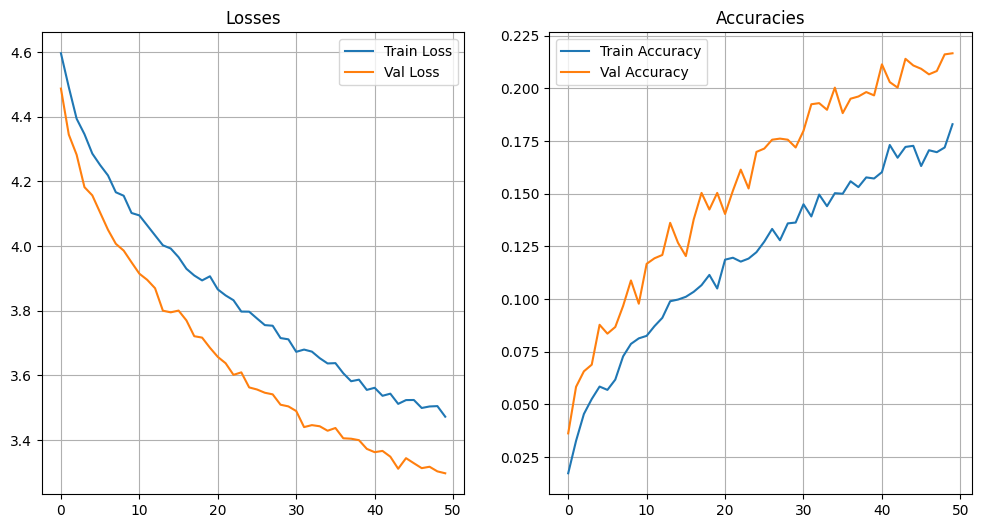

In [21]:
plot_graph(history3)

### Модель с трансфер-лернинг и продвинутой аугментацией

In [22]:
model4 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model4.fc.in_features
model4.fc = nn.Linear(num_ftrs, 100)
model4 = model4.to(device)

optimizer4 = optim.Adam(model4.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler4 = optim.lr_scheduler.ReduceLROnPlateau(optimizer4, mode='max', factor=0.5, patience=3, verbose=True)
history4 = train_model(model4, train_loader, val_loader, criterion, optimizer4, scheduler4, epochs=50)

Validation: 100%|██████████| 15/15 [00:00<00:00, 32.90it/s]


Epoch 1/50
Train Loss: 4.7808, Train Accuracy: 0.0197
Valid Loss: 4.5705, Acc: 0.0389


Validation: 100%|██████████| 15/15 [00:00<00:00, 29.76it/s]


Epoch 2/50
Train Loss: 4.4833, Train Accuracy: 0.0492
Valid Loss: 4.3059, Acc: 0.0815


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.95it/s]


Epoch 3/50
Train Loss: 4.2755, Train Accuracy: 0.0819
Valid Loss: 4.1074, Acc: 0.1099


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.74it/s]


Epoch 4/50
Train Loss: 4.1197, Train Accuracy: 0.1053
Valid Loss: 3.9339, Acc: 0.1409


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.28it/s]


Epoch 5/50
Train Loss: 3.9640, Train Accuracy: 0.1304
Valid Loss: 3.7736, Acc: 0.1730


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.53it/s]


Epoch 6/50
Train Loss: 3.8276, Train Accuracy: 0.1487
Valid Loss: 3.6092, Acc: 0.1961


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.05it/s]


Epoch 7/50
Train Loss: 3.6784, Train Accuracy: 0.1772
Valid Loss: 3.4695, Acc: 0.2103


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.50it/s]


Epoch 8/50
Train Loss: 3.5641, Train Accuracy: 0.1948
Valid Loss: 3.3397, Acc: 0.2355


Validation: 100%|██████████| 15/15 [00:00<00:00, 33.42it/s]


Epoch 9/50
Train Loss: 3.4564, Train Accuracy: 0.2192
Valid Loss: 3.2297, Acc: 0.2576


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.96it/s]


Epoch 10/50
Train Loss: 3.3662, Train Accuracy: 0.2242
Valid Loss: 3.1411, Acc: 0.2718


Validation: 100%|██████████| 15/15 [00:00<00:00, 30.85it/s]


Epoch 11/50
Train Loss: 3.2836, Train Accuracy: 0.2374
Valid Loss: 3.0543, Acc: 0.2865


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.82it/s]


Epoch 12/50
Train Loss: 3.2173, Train Accuracy: 0.2424
Valid Loss: 2.9811, Acc: 0.3044


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.64it/s]


Epoch 13/50
Train Loss: 3.1427, Train Accuracy: 0.2629
Valid Loss: 2.9193, Acc: 0.3102


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.49it/s]


Epoch 14/50
Train Loss: 3.0603, Train Accuracy: 0.2716
Valid Loss: 2.8611, Acc: 0.3207


Validation: 100%|██████████| 15/15 [00:00<00:00, 29.83it/s]


Epoch 15/50
Train Loss: 2.9954, Train Accuracy: 0.2818
Valid Loss: 2.8037, Acc: 0.3333


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.35it/s]


Epoch 16/50
Train Loss: 2.9280, Train Accuracy: 0.3003
Valid Loss: 2.7619, Acc: 0.3370


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.41it/s]


Epoch 17/50
Train Loss: 2.9110, Train Accuracy: 0.3006
Valid Loss: 2.7121, Acc: 0.3533


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.79it/s]


Epoch 18/50
Train Loss: 2.8409, Train Accuracy: 0.3194
Valid Loss: 2.6731, Acc: 0.3612


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.27it/s]


Epoch 19/50
Train Loss: 2.8111, Train Accuracy: 0.3226
Valid Loss: 2.6393, Acc: 0.3628


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.10it/s]


Epoch 20/50
Train Loss: 2.7345, Train Accuracy: 0.3320
Valid Loss: 2.6066, Acc: 0.3659


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.35it/s]


Epoch 21/50
Train Loss: 2.7128, Train Accuracy: 0.3399
Valid Loss: 2.5773, Acc: 0.3717


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.88it/s]


Epoch 22/50
Train Loss: 2.6851, Train Accuracy: 0.3536
Valid Loss: 2.5472, Acc: 0.3749


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.70it/s]


Epoch 23/50
Train Loss: 2.6512, Train Accuracy: 0.3570
Valid Loss: 2.5251, Acc: 0.3796


Validation: 100%|██████████| 15/15 [00:00<00:00, 30.63it/s]


Epoch 24/50
Train Loss: 2.5836, Train Accuracy: 0.3632
Valid Loss: 2.4961, Acc: 0.3828


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.36it/s]


Epoch 25/50
Train Loss: 2.5725, Train Accuracy: 0.3687
Valid Loss: 2.4744, Acc: 0.3849


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.64it/s]


Epoch 26/50
Train Loss: 2.5230, Train Accuracy: 0.3761
Valid Loss: 2.4539, Acc: 0.3912


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.58it/s]


Epoch 27/50
Train Loss: 2.4703, Train Accuracy: 0.3901
Valid Loss: 2.4336, Acc: 0.3875


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.81it/s]


Epoch 28/50
Train Loss: 2.4798, Train Accuracy: 0.3879
Valid Loss: 2.4165, Acc: 0.3933


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.26it/s]


Epoch 29/50
Train Loss: 2.4190, Train Accuracy: 0.3946
Valid Loss: 2.3979, Acc: 0.3933


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.42it/s]


Epoch 30/50
Train Loss: 2.4014, Train Accuracy: 0.4067
Valid Loss: 2.3825, Acc: 0.3964


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.39it/s]


Epoch 31/50
Train Loss: 2.3690, Train Accuracy: 0.4085
Valid Loss: 2.3693, Acc: 0.4022


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.41it/s]


Epoch 32/50
Train Loss: 2.3547, Train Accuracy: 0.4207
Valid Loss: 2.3568, Acc: 0.4043


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.29it/s]

Epoch 33/50
Train Loss: 2.3224, Train Accuracy: 0.4210
Valid Loss: 2.3393, Acc: 0.4075



Validation: 100%|██████████| 15/15 [00:00<00:00, 32.34it/s]


Epoch 34/50
Train Loss: 2.2783, Train Accuracy: 0.4267
Valid Loss: 2.3272, Acc: 0.4090


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.92it/s]


Epoch 35/50
Train Loss: 2.2985, Train Accuracy: 0.4281
Valid Loss: 2.3305, Acc: 0.3991


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.11it/s]


Epoch 36/50
Train Loss: 2.2917, Train Accuracy: 0.4223
Valid Loss: 2.3190, Acc: 0.4006


Validation: 100%|██████████| 15/15 [00:00<00:00, 30.69it/s]


Epoch 37/50
Train Loss: 2.2327, Train Accuracy: 0.4353
Valid Loss: 2.3087, Acc: 0.4096


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.94it/s]


Epoch 38/50
Train Loss: 2.2007, Train Accuracy: 0.4476
Valid Loss: 2.2953, Acc: 0.4148


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.71it/s]


Epoch 39/50
Train Loss: 2.1496, Train Accuracy: 0.4604
Valid Loss: 2.2829, Acc: 0.4154


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.67it/s]


Epoch 40/50
Train Loss: 2.1398, Train Accuracy: 0.4667
Valid Loss: 2.2777, Acc: 0.4143


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.79it/s]


Epoch 41/50
Train Loss: 2.1372, Train Accuracy: 0.4586
Valid Loss: 2.2699, Acc: 0.4169


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.86it/s]


Epoch 42/50
Train Loss: 2.1063, Train Accuracy: 0.4671
Valid Loss: 2.2628, Acc: 0.4143


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.81it/s]


Epoch 43/50
Train Loss: 2.0982, Train Accuracy: 0.4752
Valid Loss: 2.2542, Acc: 0.4185


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.80it/s]


Epoch 44/50
Train Loss: 2.0731, Train Accuracy: 0.4778
Valid Loss: 2.2512, Acc: 0.4169


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.89it/s]


Epoch 45/50
Train Loss: 2.0429, Train Accuracy: 0.4873
Valid Loss: 2.2471, Acc: 0.4217


Validation: 100%|██████████| 15/15 [00:00<00:00, 28.87it/s]


Epoch 46/50
Train Loss: 2.0484, Train Accuracy: 0.4811
Valid Loss: 2.2427, Acc: 0.4180


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.22it/s]


Epoch 47/50
Train Loss: 2.0240, Train Accuracy: 0.4942
Valid Loss: 2.2428, Acc: 0.4232


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.24it/s]


Epoch 48/50
Train Loss: 1.9479, Train Accuracy: 0.5125
Valid Loss: 2.2359, Acc: 0.4238


Validation: 100%|██████████| 15/15 [00:00<00:00, 31.64it/s]


Epoch 49/50
Train Loss: 1.9954, Train Accuracy: 0.4991
Valid Loss: 2.2343, Acc: 0.4311


Validation: 100%|██████████| 15/15 [00:00<00:00, 32.26it/s]

Epoch 50/50
Train Loss: 1.9515, Train Accuracy: 0.5011
Valid Loss: 2.2380, Acc: 0.4201


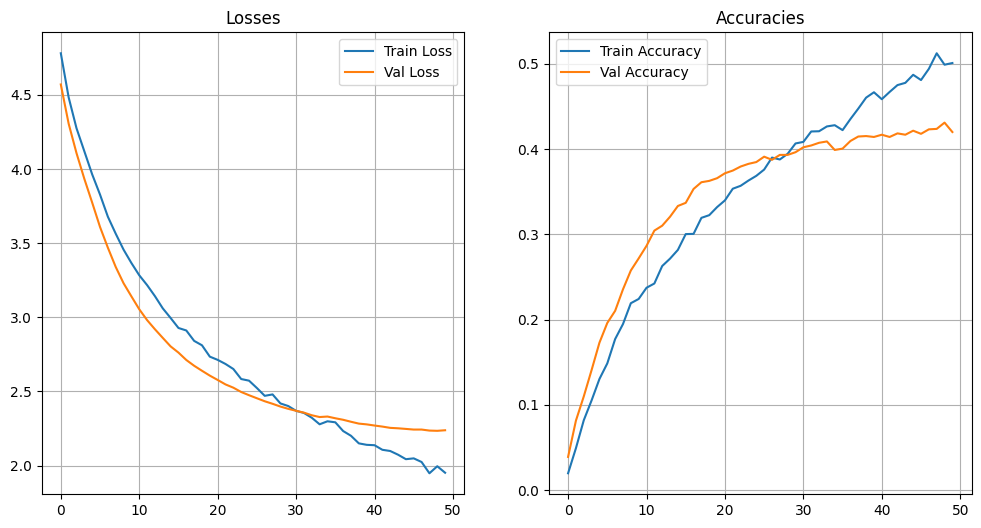

In [23]:
plot_graph(history4)

Глядя на метрики полившихся моделей попробуем собрать ансамбль различных моделей

In [ ]:
his = []
for model in ensemble_models:
    print(f"Model: {model.__class__.__name__ }")
    optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
    his.append(train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 50))

Model: EfficientNet


Validation: 100%|██████████| 15/15 [00:00<00:00, 15.24it/s]


Epoch 1/50
Train Loss: 4.7016, Train Accuracy: 0.0092
Valid Loss: 4.6728, Acc: 0.0126


Validation: 100%|██████████| 15/15 [00:00<00:00, 15.60it/s]


Epoch 2/50
Train Loss: 4.6914, Train Accuracy: 0.0108
Valid Loss: 4.6705, Acc: 0.0105


Validation: 100%|██████████| 15/15 [00:00<00:00, 17.30it/s]


Epoch 3/50
Train Loss: 4.6788, Train Accuracy: 0.0108
Valid Loss: 4.6510, Acc: 0.0110


Validation: 100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


Epoch 4/50
Train Loss: 4.6541, Train Accuracy: 0.0113
Valid Loss: 4.6250, Acc: 0.0174


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.72it/s]


Epoch 5/50
Train Loss: 4.6353, Train Accuracy: 0.0151
Valid Loss: 4.6187, Acc: 0.0179


Validation: 100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


Epoch 6/50
Train Loss: 4.6241, Train Accuracy: 0.0151
Valid Loss: 4.6265, Acc: 0.0163


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.72it/s]


Epoch 7/50
Train Loss: 4.6150, Train Accuracy: 0.0174
Valid Loss: 4.5853, Acc: 0.0237


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.69it/s]


Epoch 8/50
Train Loss: 4.5947, Train Accuracy: 0.0184
Valid Loss: 4.5795, Acc: 0.0163


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.86it/s]


Epoch 9/50
Train Loss: 4.5925, Train Accuracy: 0.0184
Valid Loss: 4.5667, Acc: 0.0231


Validation: 100%|██████████| 15/15 [00:00<00:00, 15.14it/s]


Epoch 10/50
Train Loss: 4.5846, Train Accuracy: 0.0201
Valid Loss: 4.5605, Acc: 0.0263


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.79it/s]


Epoch 11/50
Train Loss: 4.5601, Train Accuracy: 0.0260
Valid Loss: 4.5385, Acc: 0.0237


Validation: 100%|██████████| 15/15 [00:00<00:00, 15.60it/s]


Epoch 12/50
Train Loss: 4.5487, Train Accuracy: 0.0284
Valid Loss: 4.5317, Acc: 0.0331


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.50it/s]


Epoch 13/50
Train Loss: 4.5400, Train Accuracy: 0.0308
Valid Loss: 4.5247, Acc: 0.0268


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.61it/s]


Epoch 14/50
Train Loss: 4.5243, Train Accuracy: 0.0322
Valid Loss: 4.4984, Acc: 0.0415


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.45it/s]


Epoch 15/50
Train Loss: 4.5163, Train Accuracy: 0.0350
Valid Loss: 4.4823, Acc: 0.0379


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.11it/s]


Epoch 16/50
Train Loss: 4.5067, Train Accuracy: 0.0354
Valid Loss: 4.4645, Acc: 0.0442


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


Epoch 17/50
Train Loss: 4.4782, Train Accuracy: 0.0421
Valid Loss: 4.4371, Acc: 0.0431


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


Epoch 18/50
Train Loss: 4.4698, Train Accuracy: 0.0405
Valid Loss: 4.4218, Acc: 0.0521


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


Epoch 19/50
Train Loss: 4.4526, Train Accuracy: 0.0423
Valid Loss: 4.3930, Acc: 0.0552


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


Epoch 20/50
Train Loss: 4.4366, Train Accuracy: 0.0452
Valid Loss: 4.3850, Acc: 0.0584


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.61it/s]


Epoch 21/50
Train Loss: 4.4111, Train Accuracy: 0.0509
Valid Loss: 4.3467, Acc: 0.0626


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.55it/s]


Epoch 22/50
Train Loss: 4.3885, Train Accuracy: 0.0501
Valid Loss: 4.3221, Acc: 0.0710


Validation: 100%|██████████| 15/15 [00:00<00:00, 15.09it/s]


Epoch 23/50
Train Loss: 4.3826, Train Accuracy: 0.0536
Valid Loss: 4.2953, Acc: 0.0631


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


Epoch 24/50
Train Loss: 4.3439, Train Accuracy: 0.0626
Valid Loss: 4.2972, Acc: 0.0615


Validation: 100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


Epoch 25/50
Train Loss: 4.3216, Train Accuracy: 0.0627
Valid Loss: 4.2388, Acc: 0.0736


Validation:  60%|██████    | 9/15 [00:00<00:00, 15.21it/s]

In [ ]:
for h in his:
    plot_graph(h)

In [ ]:
for model in ensemble_models:
    print(f"Model: {model.__class__.__name__ }")
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)  # Берем индекс максимального логита
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    print(f'Validation Accuracy: {val_accuracy:.4f}')

In [ ]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        
        # Собираем все изображения из директории
        for fname in os.listdir(root_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(os.path.join(root_dir, fname))
        
        # Сортируем для воспроизводимости
        self.image_paths = sorted(self.image_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # Загрузка изображения
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)
        
        # Применение трансформаций
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
            
        return image, os.path.basename(img_path)  # Возвращаем тензор и имя файлаv

# Создание тренировочного датасета и DataLoader
test_dataset = TestDataset(
    root_dir=TEST_DIR,
    transform=test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

### Сохраним получившуюся модель

In [ ]:
def make_submission(ensemble_models, test_loader, train_dataset, weights=[0.097, 0.4, 0.503]):
    # Инициализация ансамбля
    class WeightedEnsemble(nn.Module):
        def __init__(self, models, weights):
            super().__init__()
            self.models = nn.ModuleList(models)
            self.weights = torch.tensor(weights, device=device).view(-1, 1, 1)
            
        def forward(self, x):
            outputs = []
            with torch.no_grad():
                for model in self.models:
                    outputs.append(model(x))
            stacked = torch.stack(outputs)
            return torch.sum(stacked * self.weights, dim=0)

    ensemble = WeightedEnsemble(ensemble_models, weights).to(device)
    ensemble.eval()

    all_preds = []
    all_files = []
    class_names = train_dataset.dataset.classes  # Получаем имена классов

    with torch.no_grad():
        for images, filenames in tqdm(test_loader, desc="Predicting"):
            images = images.to(device)
            outputs = ensemble(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_files.extend(filenames)

    # Проверка соответствия размеров
    assert len(all_preds) == len(all_files), "Mismatch between predictions and filenames!"

    submission = pd.DataFrame({
        'id': [os.path.splitext(f)[0] for f in all_files],
        'target': [class_names[p] for p in all_preds]  # Используем имена классов из train_dataset
    })

    submission.to_csv('ensemble_submission.csv', index=False)
    return submission

In [ ]:
# После обучения моделей
submission = make_submission(
    ensemble_models=ensemble_models,
    test_loader=test_loader,
    train_dataset=train_dataset,
    weights=[0.097, 0.4, 0.503]  # Оптимизируйте веса на валидации
)
print(submission.head())

### 4. Простенький генератор аугментаций

In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, num_classes, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc_mu = nn.Linear(64*56*56, latent_dim)
        self.fc_logvar = nn.Linear(64*56*56, latent_dim)
        
        self.decoder_input = nn.Linear(latent_dim + num_classes, 64*56*56)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z, labels):
        labels = nn.functional.one_hot(labels, self.num_classes).float()
        z = torch.cat([z, labels], dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 64, 56, 56)
        return self.decoder(x)

    def forward(self, x, labels):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, labels), mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

def train_vae(vae, dataloader, device, epochs=20):
    vae.train()
    optimizer = optim.Adam(vae.parameters(), lr=1e-3)
    criterion = nn.MSELoss(reduction='sum')
    
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            recon_images, mu, logvar = vae(images, labels)
            
            # Расчет потерь
            recon_loss = criterion(recon_images, images)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataloader.dataset):.4f}')
    return vae

class GeneratedDataset(Dataset):
    def __init__(self, vae, original_dataset, num_samples_per_class, device):
        self.vae = vae
        self.original_dataset = original_dataset
        self.num_samples_per_class = num_samples_per_class
        self.device = device
        self.samples = self._generate_samples()
        
    def _generate_samples(self):
        self.vae.eval()
        generated_data = []
        
        # Собираем статистику по классам
        class_counts = Counter(self.original_dataset.targets)
        
        with torch.no_grad():
            for class_idx, count in class_counts.items():
                # Генерируем недостающие примеры
                if count < self.num_samples_per_class:
                    n_samples = self.num_samples_per_class - count
                    z = torch.randn(n_samples, vae.latent_dim).to(device)
                    labels = torch.full((n_samples,), class_idx, dtype=torch.long).to(device)
                    
                    fake_images = vae.decode(z, labels).cpu()
                    for img in fake_images:
                        generated_data.append((img, class_idx))
        
        return generated_data

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, label = self.samples[idx]
        return img, label
def get_augmentation_pipeline():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Rotate(limit=30, p=0.3),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(),
        ToTensorV2()
    ])

# 5. Эксперимент с сравнением производительности
def run_experiment():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Загрузка данных
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    original_dataset = ImageFolder(TRAIN_DIR, transform=transform)
    num_classes = len(original_dataset.classes)
    
    # Инициализация и обучение VAE
    vae = ConditionalVAE(num_classes).to(device)
    dataloader = DataLoader(original_dataset, batch_size=32, shuffle=True)
    vae = train_vae(vae, dataloader, device, epochs=20)
    
    # Генерация дополнительных данных
    generated_dataset = GeneratedDataset(vae, original_dataset, 
                                       num_samples_per_class=200, 
                                       device=device)
    
    # Объединение реальных и сгенерированных данных
    combined_dataset = ConcatDataset([original_dataset, generated_dataset])
    
    # Создание аугментаций
    aug_pipeline = get_augmentation_pipeline()
    
    # Определение модели (пример)
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)
    
    # Обучение на разных наборах данных
    for dataset_type, dataset in [('Original', original_dataset),
                                 ('Combined', combined_dataset)]:
        print(f'\nTraining with {dataset_type} data')
        
        # Создание DataLoader с аугментациями
        train_loader = DataLoader(
            AugmentedDataset(dataset, aug_pipeline),
            batch_size=32,
            shuffle=True
        )
        
        # Обучение модели
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(5):
            model.train()
            for inputs, labels in tqdm(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            # Валидация
            model.eval()
            val_loader = DataLoader(original_dataset, batch_size=32)
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            print(f'Epoch {epoch+1}, Val Acc: {100*correct/total:.2f}%')